In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from main import DCTrader, DCTracker, StockDataLoader
from trainer import GATrainer, PSOTrainer

In [3]:
ticker = 'test_2'

test = StockDataLoader(ticker=ticker)
test.load_data()

test_2: 150 loaded days | 2020-01-01 to 2020-05-29


In [4]:
test.data

,Date,Close
0,2020-01-01,102.98
1,2020-01-02,103.83
2,2020-01-03,106.36
3,2020-01-04,117.14
4,2020-01-05,117.43
...,...,...
145,2020-05-25,240.19
146,2020-05-26,238.53
147,2020-05-27,232.09
148,2020-05-28,237.05


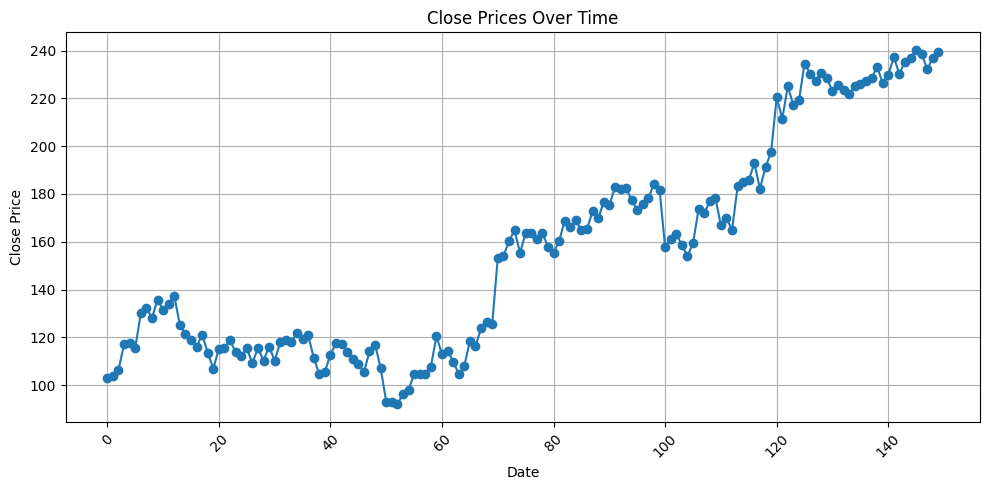

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(test.data['Close'], marker='o')
plt.title('Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
tracker = DCTracker(theta=0.06)

dc_confirmations = []

for idx, row in test.data.iterrows():
    t = idx  # Tiempo como índice entero
    p = row['Close']
    tracker.update(t, p)
    
    if tracker.is_dcc:
        dc_confirmations.append({
            'index': idx,
            'date': row['Date'].date(),
            'price': p,
            'new_trend': tracker.trend,
            'from_ext': tracker.p_ext_initial
        })

print("\n=== DC CONFIRMATIONS DETECTADAS (theta=6%) ===")
for c in dc_confirmations:
    print(f"Index {c['index']:2d} | {c['date']} | Precio {c['price']:6.2f} → {c['new_trend'].upper()} "
          f"(desde extremum {c['from_ext']:.2f})")


=== DC CONFIRMATIONS DETECTADAS (theta=6%) ===
Index  3 | 2020-01-04 | Precio 117.14 → UPTREND (desde extremum 102.98)
Index 13 | 2020-01-14 | Precio 125.21 → DOWNTREND (desde extremum 137.39)
Index 20 | 2020-01-21 | Precio 115.26 → UPTREND (desde extremum 106.87)
Index 26 | 2020-01-27 | Precio 109.29 → DOWNTREND (desde extremum 118.78)
Index 29 | 2020-01-30 | Precio 116.14 → UPTREND (desde extremum 109.29)
Index 37 | 2020-02-07 | Precio 111.45 → DOWNTREND (desde extremum 121.98)
Index 40 | 2020-02-10 | Precio 112.76 → UPTREND (desde extremum 104.60)
Index 45 | 2020-02-15 | Precio 108.92 → DOWNTREND (desde extremum 117.57)
Index 47 | 2020-02-17 | Precio 114.12 → UPTREND (desde extremum 105.42)
Index 49 | 2020-02-19 | Precio 107.12 → DOWNTREND (desde extremum 116.99)
Index 54 | 2020-02-24 | Precio  97.88 → UPTREND (desde extremum 91.91)
Index 60 | 2020-03-01 | Precio 112.89 → DOWNTREND (desde extremum 120.50)
Index 65 | 2020-03-06 | Precio 118.38 → UPTREND (desde extremum 104.63)
Index

In [7]:
print("=== ESTADO FINAL DEL TRACKER ===")
print(tracker)

=== ESTADO FINAL DEL TRACKER ===
=== DCTracker State ===
Theta: 0.0600
Current trend: uptrend
Current extreme price (p_ext): 240.190
Time of extreme (t_ext): 145
Theoretical DCC (p_dcc_star): 174.932
Initial extreme cycle: 165.030
Last DCC time: 113
Current OS length: 36
Last DC duration: 1
Is DCC now?: False
Current OSV: 6.153
Current TMV: 7.522

=== Statistics ===
DC events: 17
OS events: 15
Total DC time: 34
Total OS time: 79

Recent trends: ['downtrend', 'uptrend', 'downtrend', 'uptrend', 'downtrend']
Recent OS flags: [True, True, True, True, True]


In [8]:
from strategies import St1, St2, St3, St4, St5, St6, St7, St8

thresholds = [0.00098, 0.0022, 0.0048, 0.0072, 0.0098, 0.0122, 0.0155, 0.017, 0.02, 0.0255]
strategies = [St1, St2, St3, St4, St5, St6, St7, St8]

# Modo entrenamiento (precomputa estados)
trader = DCTrader(ticker, 
                  thresholds=thresholds,
                  strategies=strategies,
                  is_train=True)

trader.train(method='GA', pop_size=100, n_gen=50)

# Guardar el mejor modelo
trader.save_model()

Loading data for TEST_2...
test_2: 150 loaded days | 2020-01-01 to 2020-05-29
Precomputation of signals completed.
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
Starting training with GA...
Iniciando entrenamiento GA | Población: 100 | Generaciones: 50
Dimensión de pesos: 70
Gen   1 | Fit: 2.448
Gen  10 | Fit: 4.148
Gen  20 | Fit: 4.585
Gen  30 | Fit: 4.857
Gen  40 | Fit: 5.283
Gen  50 | Fit: 5.283

Entrenamiento GA completado | Mejor fitness: 5.2829
Pesos óptimos asignados al modelo.
Training completed. Optimal weights assigned to the model.
Running backtest...
Backtest completed → RoR: 184.96% | SR: 5.183 | Trades: 25
Model saved to ../persistency/TEST_2_model.pkl


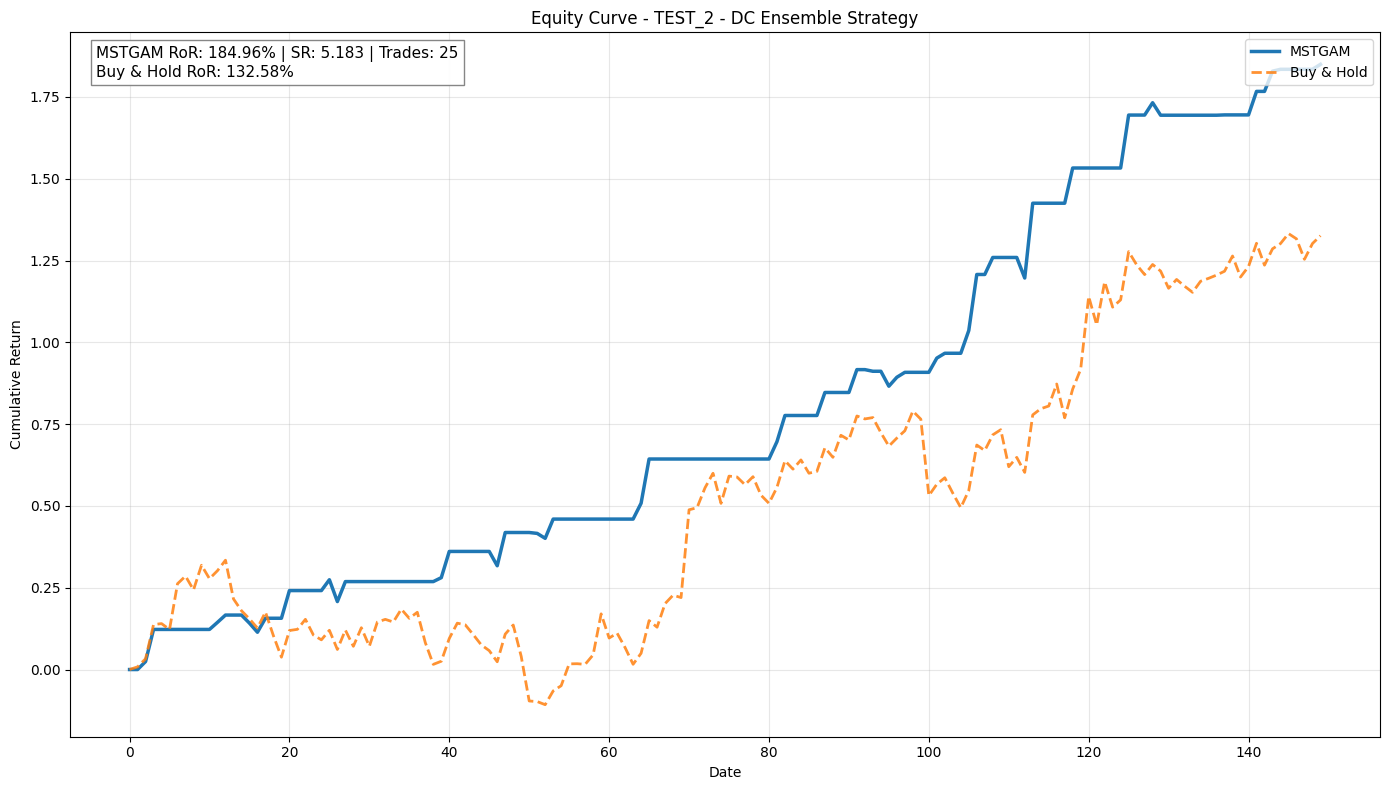

In [9]:
# Ver resultados
trader.plot_equity()

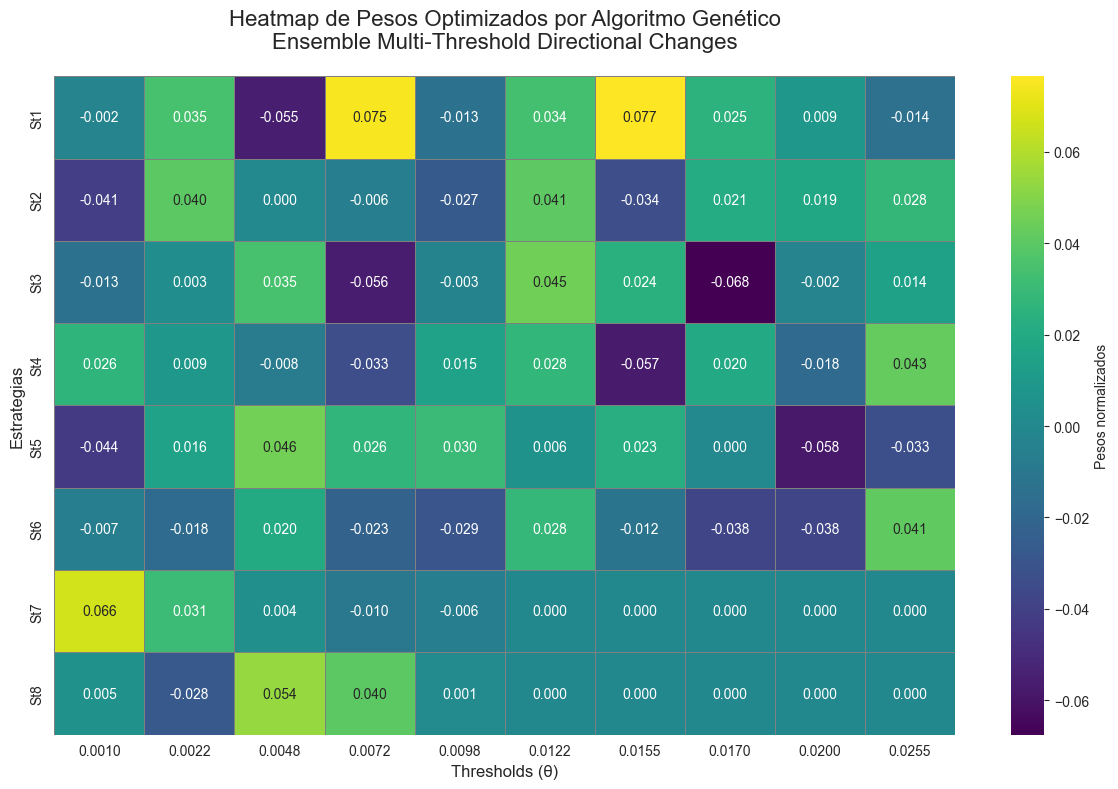

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener la matriz de pesos (n_strats x n_ths)
weights = trader.model.weights  # shape: (8, 10)

# Nombres para los ejes
strategy_names = [f'St{i+1}' for i in range(weights.shape[0])]
threshold_values = [f'{th:.4f}' for th in trader.extractor.thresholds]  # valores reales de theta

# Configuración general de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# =====================================================
# Heatmap de pesos completos
# =====================================================
plt.figure(figsize=(12, 8))
sns.heatmap(
    weights,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Pesos normalizados'},
    xticklabels=threshold_values,
    yticklabels=strategy_names,
    annot_kws={"size": 10}
)

plt.title('Heatmap de Pesos Optimizados por Algoritmo Genético\n'
          'Ensemble Multi-Threshold Directional Changes',
          fontsize=16, pad=20)
plt.xlabel('Thresholds (θ)', fontsize=12)
plt.ylabel('Estrategias', fontsize=12)
plt.tight_layout()
plt.show()